In [1]:
%matplotlib inline
import numpy as np
from scipy.signal import savgol_filter
import peakutils # package avaiable in Pip, can do gaus fitig and local maxima fiting:)
from peakutils.plot import plot as pplot
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
version = '1.2'

In [2]:
#Sets the cell width to certan procentage
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Import function for json database files

In [3]:
def json_data_read_reduce(file_path, start = 20, stop = 120, min_amp=20):
    '''read in json files from "https://www.materialsproject.org" for xrd data,
    and transform them to one numpy array of 2theta data for comparson.
    
    Parameters
    ----------
    file_path:  file path string with ending e.g.: "Y2WO6_mp-565796_xrd_Cu.json"
    start:      start of relevant positions in degree, default 20
    stop:       stop of reavant position, default 120
    min_amp:    minmal amplitude of calues considered
    
    Returns
    -------
    two_theta value array
    
    Exaple
    ------
    '''
    #import dependeces
    import json
    import numpy as np
    
    #open file and assine to d
    with open(file_path) as json_data:
        d = json.load(json_data)
        
    #produce array with the same length as data
    amplitude = np.zeros(len(d[u'pattern'][:]))
    two_theta = np.zeros(len(d[u'pattern'][:]))
    #loop through the length of data and assine (fill) the arrays with the data
    for i in range(len(d[u'pattern'][:])):
        amplitude[i] = d[u'pattern'][i][0]
        two_theta[i] = d[u'pattern'][i][2]
    
    #filter only revant, data which was measured
    start_stop = (start <= two_theta) & (two_theta <= stop)
    #print two_theta[start_stop]
    #filter only data with relevant amplitude here, default higher or equal 25%
    minimal_amp = (amplitude > min_amp)
    #print amplitude[minimal_amp]
    #filter the two_theta array
    
    #return the filtered array of the json file
    return two_theta[start_stop & minimal_amp]

### Test if import wokrs

In [4]:
Y6WO12 = json_data_read_reduce('daten_bank/Y6WO12_mp-19005_xrd_Cu.json')
print 'Y6WO12', len(Y6WO12), Y6WO12

Y6WO12 6 [28.42636114 29.20471251 33.62374459 47.78369588 48.78884306 57.43435056]


## Creating data base for oxide fitting

# Peak Database

In [5]:
W = [40.265,58.276,73.198,87.024]
Cr = [44.393, 64.5447, 81.724, 98.0349] #self fitted only if needed
Cr2O3 = [24.494,33.597,36.196, 39.749, 41.480, 44.194, 50.220, 54.852, 57.111, 58.397,
         63.449, 65.106, 72.944, 73.329, 76.851, 79.056,
         82.092, 84.239, 85.682, 86.539, 90.202, 95.328]#  33.597
WO3 = [23.083,23.707,24.099,25.956,26.587,28.776,33.331,33.640,34.022,35.525,41.524,44.880,45.354,47.228,48.431,49.326
       ,50.079,50.494,53.480,53.683,54.302,55.116]# 33.640  ,54.794,55.404]#,55.844,59.472,60.242,60.810,62.121,62.446]
#WO283 = [23.485, 23.181, 33.242, 48.077, 53.615, 59.388, 54.025]
#W8O21 = [23.498, 26.038, 26.882, 31.316, 48.064, 36.000, 39.521]
WO279 = [23.512,28.214,37.044,48.093,56.694]
Cr2WO6 = [20.008,21.827,27.513,34.258,36.137,39.308,44.488,45.411,54.461,56.813,62.834,64.260,69.222,70.125,89.778]
YO = [29.410]#,34.038,48.888,58.075]
CrWO4 = [19.154, 26.750, 27.681, 30.624, 36.373, 38.871, 41.089, 42.994, 44.301
         ,50.256, 53.751, 54.794, 55.080, 57.207, 62.728, 63.736, 64.228, 68.653, 70.299, 70.663]#]
Y2WO6 = json_data_read_reduce('daten_bank/Y2WO6_mp-565796_xrd_Cu.json')
Y6WO12 = json_data_read_reduce('daten_bank/Y6WO12_mp-19005_xrd_Cu.json')
Y2WO6_2 = json_data_read_reduce('daten_bank/Y2WO6_2_mp-510132_xrd_Cu.json')

# filling vlaues into dic to call at key of oxide in the fitting loop
dic = { 'Cr$_2$O$_3$':sort(Cr2O3), 'WO$_3$': sort(WO3),
       'WO$_{2.79}$':sort(WO279),'Cr$_2$WO$_6$':sort(Cr2WO6)
       #,'CrWO$_4$':CrWO4\
       #,'Y$_2$WO$_6 ^*$': np.sort(np.append(Y2WO6,Y2WO6_2))
       ,'Y$_6$WO$_{12} ^*$' : Y6WO12
      }#'Y$_2$O$_3$':[29.410,34.038,48.888,58.075]#WO283+W8O21+
#'Cr':[44.393,81.724,64.5447],#'W' : [40.265,58.276,73.198,87.024],

#dic for maker 'name': [marker,'traffic-light-color',marker of set to get red at top yellow, and green]
dic_marker =  { 'Cr$_2$O$_3$':['h','g',0.], 'WO$_3$': ['D','r',0.2]
               ,'WO$_{2.79}$':['^','r',0.2],'Cr$_2$WO$_6$':['D','y',0.1]
               ,'Y$_2$O$_3$': ['.','g',0.],'CrWO$_4$':['*','y',0.2]
               ,'Y$_2$WO$_6 ^*$': ['d','y',0.1]
               ,'Y$_6$WO$_{12} ^*$': ['v','y',0.1]}

print dic_marker

{'Cr$_2$O$_3$': ['h', 'g', 0.0], 'WO$_3$': ['D', 'r', 0.2], 'Y$_2$WO$_6 ^*$': ['d', 'y', 0.1], 'WO$_{2.79}$': ['^', 'r', 0.2], 'Cr$_2$WO$_6$': ['D', 'y', 0.1], 'Y$_2$O$_3$': ['.', 'g', 0.0], 'CrWO$_4$': ['*', 'y', 0.2], 'Y$_6$WO$_{12} ^*$': ['v', 'y', 0.1]}


## Defining ordering function for multi peak analyses

In [6]:
def peak(x,lambd=1.5418):
    '''Calculates the lattice constance for bcc metals and alloys
    and only takes one plane after the other of the XRD 
    to fit the constance. To avoid mix up of planes. 
    The used order and the  given boundarys are (110) with 39.6 <x) & (x<44.4), 
    (200)(57. <x) & (x< 65.), (211)(73. <x) & (x< 85.),(220) (86.6 <x) & (x< 99.) 
    for W-Cr alloys. 
    x = fitted position in 2Theta (°)
    lambd = wavelength of the Kathode metal in angstrom default is Cu. If other source is used
    or if Ka2 is stripe, give the correct value
    
    \retun: tuple yf np.arrays of fitted constant'''
    
    a, b, c, d, e, f, g, h = 40.23, 44.41, 58.1, 64.6, 73.17, 81.78, 86.9, 98.04
    x = np.array(x)#39.6
    x = x[(a <x) & (x< b) ^ (c <x) & (x< d) ^ (e <x) & (x< f) ^ (g <x) & (x< h)]
    #Lattice constant a for the (110) plane
    a_110 = np.array(lambd/np.sin(x[(a <x) & (x < b)]*np.pi/180/2)/2**0.5)
    a_200 = np.array(lambd/np.sin(x[(c <x) & (x < d)]*np.pi/180/2))
    #appen calculated a's for panes (110) and (200)
    a_12 = np.append(a_110, a_200)
    a_211 = np.array(0.5*lambd/np.sin(x[(e < x) & (x < f)]*np.pi/180/2)*6**0.5)
    a_220 = np.array(0.5*lambd/np.sin(x[(g <x) & (x< h)]*np.pi/180/2)*8**0.5)
    a_34 = np.append(a_211, a_220)
    #appen all in one np.array
    a = np.append(a_12,a_34)
    return a

def relevant(x):
    '''Clulating the peak position wich are really condsideren in the callulation above
    return list of values, Further more it gives back the list of the index
    
    Returns
    _______
    r the array of filtered values which are relevant
    and y an array of binary values to use the filter on other arrays with the same length'''
    a, b, c, d, e, f, g, h = 40.23, 44.41, 58.1, 64.6, 73.17, 81.78, 86.9, 98.04
    x = np.array(x)
    r =  x[(a <x) & (x< b) ^ (c <x) & (x< d) ^ (e <x) & (x< f) ^ (g <x) & (x< h)]
    y =   [(a <x) & (x< b) ^ (c <x) & (x< d) ^ (e <x) & (x< f) ^ (g <x) & (x< h)]
    return r, y

def irrelevant(x):
    '''Clulating the peak position wich should not be condsideren in the callulation above
    
    Returns
    ________
    List of values, Further more it gives back the list of the index'''
    a, b, c, d, e, f, g, h = 40.23, 44.41, 58.1, 64.6, 73.17, 81.78, 86.9, 98.04
    x = np.array(x)
    #r =  x[(a <x) & (x< b) ^ (c <x) & (x< d) ^ (e <x) & (x< f) ^ (g <x) & (x< h)]
    y =   (a <x) & (x< b) ^ (c <x) & (x< d) ^ (e <x) & (x< f) ^ (g <x) & (x< h)
    y = np.logical_not(y)
    return y

#searchsort numpy based fitting ---> very fast and precise /prone if values overlap in the uncertanty range
def ox_index(a, b, uncertanty = 0.06, sort = False, unique = False, reduce_to_relevant = False):
    r'''Finds peaks in the uncertanty range (default [-0.06, 0.06]) that fit database entry
    givening back index peakpostion that doas fit the data base. 
    Base on the numpy.searchsorted function
    (https://docs.scipy.org/doc/numpy/reference/generated/numpy.searchsorted.html)
    Parameters
    ----------
    a : array of values (here peak postisions)
    b : array of values to compare to (here, litreture angels to expect)
    uncertanty : expected uncertanty, where the data should fit in [-lower,upper]
    Returns
    -------
    index of vlaues in the array a vlues which fit b array
    Notes
    -----
    gives back measurd values, which fit to the database (in the given uncertanty range) both array have to be sorted!!
    Examples
    --------
    measured_values = np.array([12.01,13.001,14.001,15.001,15.6,15.9999])
    database = np.array([12.,13.,14.,15.,16.])
    print measured_values[Ox_index(measured_values,database)]
    >>> [ 12.01    13.001   14.001   15.001   15.9999]
    
    It also works in both directions:
    a = np.array([1.01,2.01,2.5,3.01,3.999,4.0001,6,7,9,89])
    b = np.array([1.,2.,3.,4.,6])
    print 'a',a[Ox_index(a,b)]
    print 'b',b[Ox_index(b,a)]
    print np.abs(a[Ox_index(a,b)]-b[Ox_index(b,a)]).mean()
    >>>a [ 1.01    2.01    3.01    3.999   4.0001  6.    ]
    >>>b [ 1.  2.  3.  4.  4.  6.]
    >>>0.00518333333333
    '''
    import numpy as np
    
    #check which data type and correct to np.array if needed
    if type(a) != "<type 'numpy.ndarray'>":
        a = np.array(a)
    if type(b) != "<type 'numpy.ndarray'>":
        b = np.array(b)
    
    # if wanted sort input array a other wise search sort evetnualy falls
    if sort == True:
        a = np.sort(a)
        #b = np.sort(a)
    
    # optinal, reduce input arrays to unique values:
    if unique == True:
        a = np.unique(a)
        b = np.unique(a)
    
    # optional, reduces the input arrays, so that the longer array a values, 
    #fall in the range of the short array b
    # and visa versa
    if reduce_to_relevant == True:
        a = a[((b.min()-uncertanty)<a) & (a<(b.max()+uncertanty))]
        b = b[(a.min()<(b-uncertanty)) & ((b+uncertanty)<a.max())]
    
    #main function: finding indexes which are the intersection of the 
    #lower and higher uncertanty range of a in b
    x = np.searchsorted(a,b-uncertanty,side='left')
    y = np.searchsorted(a,b+uncertanty,side='left')-1
    index = x[x==y]
    return  index #retuns the index of the fitting parts of the array

# Sample Selection and Read in of the Folder and Fitting Data

In [7]:
#Folder = '26WCrY_Sa11'   # Folder where all data files which shall be used are found (and no other files)
#Folder = '27WCrY_Sa04'

#Folder = '16WCrY_Sa'
##################Folder = 'CrReihe' ## load data is missing take from Felix...!!!!!!!!!
#Folder = '33WCrY'
######################Folder = 'YReihe'
#Folder = 'NonOx'
#Folder = '34WCrY_Sa06'
#Folder = '01WCrY_3hMa'

###################### PHD Thesis
#Folder = 'W_powder'
#Folder = 'Powder_overview'  # put in finished!! check double put in
#Folder = 'Bulk_Powder'     #finished

#Folder = 'LowpO2'          #finishhed
#Folder = 'Phasen'          #finished

#Folder = 'LowPO2_bulk'     #finisched
#Folder = 'Bulk_rough_smoth' #finished
Folder = 'Bulk_thin_comp'  #finished
#Folder = 'Bulk'

CurrentDirectory = os.curdir # defines the current file where this code is saved
meas = os.listdir('%s/%s/data'%(CurrentDirectory,Folder)) # define list of data sets in the folder
dataSets = []
meas.sort() # sorting alphabetecly the file names%%% added by Tobias
sec = []

for i in range (0,len(meas)): # create data arrays
    data = np.genfromtxt('%s/data/%s'%(Folder,meas[i]), skip_header = 1)
    sec.append(data[:,1].max()) ##Defining secons from the highest peak so peaks get highest peaks without overlapping
    dataSets.append(data)
name = meas
print name

['01_BB_FAST2063_02-1273K,44h,ArO2,standardgrinding_exported.xy', '02_BB_19WCrY_Sa04_exported.xy', '03_BB_33WCrY_Sa04_exported2hOx.xy']


## Default values for the different folders and list of exceptions

In [8]:
name = [0]*len(meas) # create array containing all the names of the ploted data
#Default sizes
minpeak = None 
print minpeak
peakhight = 140.0 # hight of the resulting peak
col_change = False #changes the order of color, only usable for 3 colors?
minimal_count = 2 # minimal count of peaks for xrd phase for vergards concentration caculation
left = False
cale =1.28
scale = peakhight*cale
Smooth = 2 #devides and makes the the smoothing window smaller if chosen higher

#No oxide phase shell be fitted
list_of_none_oxed = ['W','Cr','3.0$\,$h \nLow $p_{\mathrm{O}_2}$','0.0$\,$h','FAST7 initial'
                     ,'As produced','FAST7 befor Ox']
#where not metal phase is measured (shielded by the thick oxide layer)
list_of_none_metal = ['FAST7 rough','FAST6 humid 251$\,$h', u'CEIT \nW-10Cr-0.5Y \n10 h ox',u'FAST4']
# list of exceptions when a singal additional usfull peak is to be analyse the alloy composition
exeption = [u'W-11.4Cr-0.6Y\n 3.5$\,$µm 2$\,$h Ox',u'W-11.4Cr-0.6Y\n 3.5 µm 2$\,$h Ox', '2.0$\,$h',
            'FAST7',u'FAST7 initial', u'FAST7 befor Ox',u'FAST7 3$\,$h 1273$\,$K','FAST6',u'FAST6', 
            u'FAST6 3523$\,$µm\n 44$\,$h Ox','16$\,$h','3$\,$h']
# if the gausian second fittig methode is not wanted (less precize fitting)
non_gausian_metal = ['40$\,$h']

if Folder == 'Powder_overview': ## this one is the more default one use for other parameters as well..
    name[0] = 'W'
    name[7] = 'Cr'
    name[1] = '3$\,$h'
    name[2] = '16$\,$h'
    name[3] = '40$\,$h'
    name[4] = '60$\,$h-0.6Y'
    name[5] = '60$\,$h-1.0Y'
    name[6] = '60$\,$h-1.5Y'
    Xmin = 30.
    Xlim = 110. # maximal shown X value
    pos = 16
    metal = True
    oixdes = False
    #Metal
    minpeak2 = 6.#
    peaknumber2 = 100.#65
    wid = 2
    minimal_count = 0
    left = True
    
if Folder == 'Bulk':
    name[0] = 'FAST3'
    name[1] = u'FAST4'
    name[2] = u'FAST6'
    name[3] = u'FAST7'
    #name[4] = u'CEIT \nW-10Cr-0.5Y \n10 h ox'
    pos = 16
    metal = True
    oixdes = True
    minimal_count = 2
    minpeak2 = 4#6#0.08
    peaknumber2 = 80
    left = True
    
if Folder == 'Bulk_Powder':
    #name[0] = 'W'
    #name[1] = 'Cr'
    #name[2] = '40$\,$h'
    name[0] = '60$\,$h-0.6Y'
    name[1] = 'FAST1 40$\,$h'
    name[2] = 'FAST2a'
    name[3] = 'FAST3'
    name[4] = 'FAST4'
    name[5] = 'FAST5'
    name[6] = 'FAST6'
    name[7] = 'FAST7'
    Xmin = 30.
    Xlim = 100.
    pos = 16
    metal = True
    oixdes = False
    minimal_count = 2
    left = True
    
if Folder == 'W_powder':
    name[0] = 'W'
    #sec = [2000]
    hight = 70
    pos = 5
    metal = True 
    oixdes = False
    
if Folder == 'Phasen':
    name[0] = u'3.0$\,$h \nLow $p_{\mathrm{O}_2}$'
    name[1] = '0.0$\,$h'#
    name[2] = '0.1$\,$h'
    name[3] = '1.25$\,$h'
    name[4] = '2.0$\,$h'
    name[5] = '3.0$\,$h'
    name[6] = '8.0$\,$h'
    #name[5] = 'long'
    pos = 16
    metal = True
    oixdes = True
    minimal_count = 1
    left = True

if Folder == 'LowpO2':
    name[2] = u'As produced'
    name[1] = u'W-Cr, 3$\,$h'
    name[0] = u'W-Cr-Y, 3$\,$h'
    #name[3] = '0.1 h'
    pos = 77#80---10
    metal = True
    oixdes = False
    minimal_count = 1
    left = True

if Folder == 'CrReihe':
    name[0] = 'W-8.1Cr-0.36Y'
    name[1] = 'W-10.0Cr-0.31Y'
    name[2] = 'W-11.7Cr-0.35Y'
    name[3] = 'W-13.5Cr-0.41Y'
    Xlim = 120. # maximal shown X value
    pos = 16
    metal = True
    oixdes = True
    

if Folder == 'LowPO2_bulk':
    #name[0] = 'W powder'
    #name[1] = 'Cr powder'
    name[0] = u'FAST7 initial'
    name[1] = u'FAST7 3$\,$h 1273$\,$K'
    pos = 17#78
    metal = True
    minpeak2 = 4#6#0.08
    peaknumber2 = 80
    oixdes = False
    minimal_count = 1
    left = True

if Folder == 'Bulk_thin_comp':
    #name[0] = 'W powder'
    #name[1] = 'Cr powder'
    name[2] = u'W-11.4Cr-0.6Y\n 3.5$\,$µm 2$\,$h Ox'
    name[1] = u'W-13.5Cr-1.1Y\n 7.5$\,$µm 6$\,$h Ox'
    name[0] = u'FAST6 3523$\,$µm\n 44$\,$h Ox'
    pos = 16
    metal = True
    oixdes = True
    minimal_count = 2
    minpeak2 = 4#6#0.08
    peaknumber2 = 80
    left = True
    
if Folder == 'Bulk_rough_smoth':
    name[0] = u'FAST7 befor Ox'
    name[1] = 'FAST7 standard'# 44 h Ox'
    name[2] = 'FAST7 rough'# 44 h Ox'
   # name[3] = 'FAST6 humid 251$\,$h'
    pos = 16
    #col_change = True
    metal = True
    oixdes = True
    minpeak = 0.045#0.08
    peaknumber = 200
    minimal_count = 2
    left = True
    #oxide
    minpeak = [0.03,0.02,0.06]#*len(name)
    peaknumber = [150]*len(name)
    #metal
    minpeak2 = [10.]*len(name)#8.3#4#8.1##0.06#0.08 #percent of maximal peak
    peaknumber2 = [100.]*len(name)#65

    

if oixdes == True:
    start = 20
    stop = 100
else:
    start = 39
    stop = 95

print 'SETTINGS:\n'
print Folder, name
print 'start-stop',start, stop


None
SETTINGS:

Bulk_thin_comp [u'FAST6 3523$\\,$\xb5m\n 44$\\,$h Ox', u'W-13.5Cr-1.1Y\n 7.5$\\,$\xb5m 6$\\,$h Ox', u'W-11.4Cr-0.6Y\n 3.5$\\,$\xb5m 2$\\,$h Ox']
start-stop 20 100


## Plot Settings

In [9]:
%config InlineBackend.figure_format='svg'
# Update the matplotlib configuration parameters:
matplotlib.rcParams.update({'font.size': 14, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
matplotlib.rcParams['svg.fonttype'] = 'none'

from matplotlib import rc
rc('lines', lw=1.5)
if len(name)>8:
    color= cm.tab10(np.linspace(0,1,len(name)))#Dark2
else:
    color= cm.Dark2(np.linspace(0,1,len(name)))
    color = color[::-1]#reversed for comparison to other oxidation graph
    
if col_change == True:
    cole = [1,0,-1]
    #color = color[cole]

print len(name)
if len(name)<5:
    hight = len(name)*2.
else:
    hight = len(name)*1

rc('figure', figsize=(6.2, hight))

print hight

3
6.0


# Peak fitting
## Calculate Cr content in W-Cr phase from peakshift relative to the tungsten peak

In [10]:
aCr = 2.8846#2.8846#2.885 # lattice constant chromium in angstrom 288.46 
aW = 3.16  # lattice constant tungsten in angstrom
lambd = 1.54184 # wavelength of the x-ry Cu source in angstrom
atomicMassW = 183.84
atomicMassCr = 51.9961

## Check if fitt settings are aproriet for the sample investigated
### Change mindpeak and peaknumber variable for oxide fitting
For different peak fitting parameter, list can be filled

### Current folder and samples

In [11]:
print Folder
print name

Bulk_thin_comp
[u'FAST6 3523$\\,$\xb5m\n 44$\\,$h Ox', u'W-13.5Cr-1.1Y\n 7.5$\\,$\xb5m 6$\\,$h Ox', u'W-11.4Cr-0.6Y\n 3.5$\\,$\xb5m 2$\\,$h Ox']


W-11.4Cr-0.6Y
 3.5$\,$µm 2$\,$h Ox 20 pixel/° window = 11 0.04
W-13.5Cr-1.1Y
 7.5$\,$µm 6$\,$h Ox 20 pixel/° window = 11 0.05


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))
/usr/local/lib/python2.7/dist-packages/peakutils/peak.py:216: UserWarning: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
  warnings.warn(str(e))


FAST6 3523$\,$µm
 44$\,$h Ox 20 pixel/° window = 11 0.03
Bulk_thin_comp


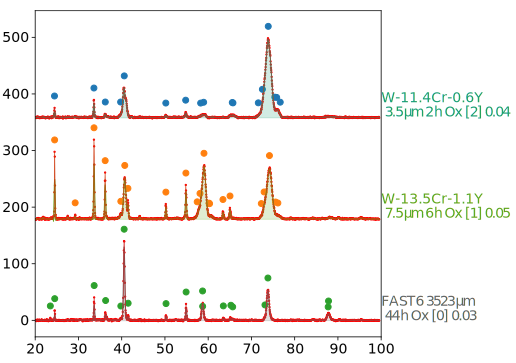

In [12]:
#default
#if 'minpeak' not in locals():
minpeak = [0.04]*len(meas)
peaknumber = [150]*len(meas)
#HERE set your wanted values

#if Folder == 'Bulk_rough_smoth':
#    minpeak = [0.02,0.04,0.05]#*len(meas)
#    peaknumber = [150]*len(meas)
if Folder == 'Bulk_thin_comp':
    minpeak = [0.03,0.05,0.04]#*len(meas)
    peaknumber = [150]*len(meas)
if Folder == 'Bulk':
    minpeak = [0.03]*len(meas)
    peaknumber = [150]*len(meas)

Smooth = 2
if oixdes == True:
    for i in reversed(range(0,len(meas))):
        x_all = dataSets[i][:,0]
        x = x_all[(start < x_all) & (x_all < stop)]
    
    
        y = peakhight/sec[i]*(dataSets[i][(start <x_all) & (x_all<stop),1])+scale*i
        ## smoothing the data for the fit, makes fiitig more reliable:
        window = (len(x)/(stop-start))/Smooth
        window = window if window%2 != 0 else window+1#checks is window is odd
        y_smooth = savgol_filter(y, window_length=window, polyorder=3)
        print name[i],len(x)/(stop-start),u'pixel/°', 'window =',window, minpeak[i]
    
        plot(x,y_smooth,c=color[i],lw=1,label='smoothed data')
        plot(x,y,c=color[i],lw=0.5,color='red')
    
        scatter(x,y,s=2,c='red',label='data' if 'data' not in plt.gca().get_legend_handles_labels()[1] else '')
    
        fill(x, y, zorder=10,color=color[i],alpha=0.2)
        plt.text(stop,peakhight/sec[i]*(dataSets[i][100,1])+scale*i, name[i]+' [{}] {:.2f}'.format(i,minpeak[i]), color=color[i])#prints the name to the line
        #fitiing and ploting
        indexes = peakutils.indexes(y, thres=minpeak[i], min_dist=len(x)/peaknumber[i]) #finding peak index position /max(y)
        #print type(indexes),indexes
        peaks_x = peakutils.interpolate(x, y, ind=indexes, width = window)#gausian fit better presition
        peaks_x = np.where(np.abs(peaks_x-x[indexes])>1.,x[indexes],peaks_x)#check wrong fit
        #print name[i],peaks_x[6], y[Ox_index(y[indexes],y,uncertanty=[-3,3])]
        #y_peak = y[Ox_index(y[indexes],y,uncertanty=[-3,3])]
    

        #check if at given x value y value fits the data
    
        #x[Ox_index(peaks_x,x,uncertanty=[-0.02,0.02])]
        #scatter(x[Ox_index(peaks_x,x,uncertanty=[-0.02,0.02])],y[Ox_index(peaks_x,x,uncertanty=[-0.02,0.02])])
        if (oixdes==True):# and (name[i] not in list_of_none_oxed)
            scatter(peaks_x,y[indexes]+0.15*peakhight)
        #print name[i], peaks_x

    xlim(start, stop)
    #legend()
    #xlim(70, stop)
print Folder

### Change mindpeak2 and peaknumber2 variable for alloy phase fitting

[8, 14, 10]


(20, 100)

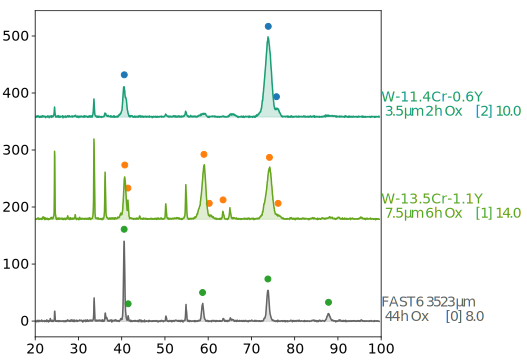

In [13]:
#Metal

#if 'minpeak2' not in locals():
minpeak2 = [12]*len(name)#8.3#4#8.1##0.06#0.08 #percent of maximal peak
peaknumber2 = [90.]*len(name)#65

if Folder == 'Bulk_rough_smoth':
    minpeak2 = [2.1,2,2]#*len(name)
    peaknumber2 = [80.]*len(name)#65
if Folder == 'LowPO2_bulk':
    minpeak2 = [2, 2]#*len(name)# [1] 1.0 #percent of maximal peak
    peaknumber2 = [120.]*len(name)#65
if Folder == 'Bulk_thin_comp':
    minpeak2 = [8,14,10]#*len(name)#8.3#4#8.1##0.06#0.08 #percent of maximal peak
    peaknumber2 = [90.,110.,90.]#*len(name)#65
if Folder == 'Phasen':
    minpeak2[6],minpeak2[5], minpeak2[4], minpeak2[1], minpeak2[0] = 5,2.2,12,8,6
if Folder == 'Bulk_Powder':
    minpeak2 = [4.4]*len(name)#8.3#4#8.1##0.06#0.08 #percent of maximal peak
    peaknumber2 = [90.]*len(name)#65
    minpeak2[0]= 5
    Smooth = 2 #deider for window for smoothing
if Folder == 'Powder_overview':
    minpeak2 = [6]*len(name)#8.3#4#8.1##0.06#0.0,8 #percent of maximal peak
    peaknumber2 = [90.]*len(name)#65
    minpeak2[1], minpeak2[2], minpeak2[3], minpeak2[6] , minpeak2[7] = 2, 3.5, 5, 8,4
    peaknumber2[3] = 80
if Folder == 'Bulk':
    minpeak2 = [6]*len(meas)
    peaknumber2 = [90.]*len(meas)

print minpeak2

#color = color[bla]
for i in reversed(range(0,len(meas))):
    x_all = dataSets[i][:,0]
    x = x_all[(start < x_all) & (x_all < stop)]
    y = peakhight/sec[i]*(dataSets[i][(start <x_all) & (x_all<stop),1])+scale*i
    ##smoothing data
    window = (len(x)/(stop-start))/Smooth
    window = window if window%2 != 0 else window+1#checks is window is odd
    #print 'window',window
    y_smooth = savgol_filter(y, window_length=window, polyorder=3)
    plot(x,y,c=color[i])
    fill(x, y, zorder=10,color=color[i],alpha=0.2)
    plt.text(stop,peakhight/sec[i]*(dataSets[i][100,1])+scale*i, name[i]+'\t[{}] {:.1f}'.format(i,minpeak2[i]), color=color[i])
    #prints the name to the line
    
    
    if (metal == True):# and (name[i] not in list_of_none_metal):#can be turned on if filter list should apply
        indexes = peakutils.indexes(y_smooth, thres=minpeak2[i]/peakhight, min_dist=len(x)/peaknumber2[i])
        #finding peak index position /max(y)
        peaks_x2 = peakutils.interpolate(x, y_smooth, ind=indexes, width=window)#gausian refit for better precision
        if name[i] in non_gausian_metal:
             peaks_x2 = x[indexes]
        peaks_x2 = np.where(np.abs(peaks_x2-x[indexes])>1.,x[indexes],peaks_x2)#check wrong fit
        aWCr = peak(peaks_x2)#calulating the lattice constant for the bcc phase
        x_reduced, yin = relevant(peaks_x2)# reducing all peaks to the relevant bcc ones  (here just metal)
        y_reduced = y_smooth[indexes[yin]]#same for peakhight
        colorX = color[i]
        scatter(x_reduced,y[indexes[yin]]+0.15*peakhight)
        #scatter(x_reduced,y[indexes[yin]]+0.15*peakhight)
        
        #print name[i], aWCr # print name and lattice constant for given peak
        
xlim(start,stop)
#xlim(60,90)
#xlim(70, 80)#, stop)

# Plot

W-11.4Cr-0.6Y
 3.5$\,$µm 2$\,$h Ox
3 0.032 standart deviation lattice constant
ON!!length3 [3.07447158 3.14165812 3.14286006]
small number of peaks<=4 bin_num= 3
len(bins) 3 [3.07447158 3.10866582 3.14286007]
FILTERT with>1 [False False  True]
FILTERT expection with=1, [False  True  True] [1 2]
Cr$_2$O$_3$ 4 0.030
Cr$_2$WO$_6$ 0 nan
WO$_3$ 1 0.060
WO$_{2.79}$ 0 nan
Y$_6$WO$_{12} ^*$ 1 0.044


W-13.5Cr-1.1Y
 7.5$\,$µm 6$\,$h Ox
7 0.066 standart deviation lattice constant
ON!!length7 [2.93252528 3.06148922 3.07168269 3.0813506  3.13006114 3.13173932
 3.13416176]
big number of peaks>4
len(bins) 6 [2.93252528 2.97285258 3.01317988 3.05350717 3.09383447 3.13416177]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cr$_2$O$_3$ 9 0.024
Cr$_2$WO$_6$ 5 0.029
WO$_3$ 2 0.027
WO$_{2.79}$ 0 nan
Y$_6$WO$_{12} ^*$ 2 0.014


FAST6 3523$\,$µm
 44$\,$h Ox
5 0.027 standart deviation lattice constant
ON!!length5 [3.07781867 3.14377669 3.14456365 3.14461252 3.14531969]
big number of peaks>4
len(bins) 5 [3.07781867 3.09469393 3.11156919 3.12844445 3.1453197 ]
FILTERT expection with=1, [False  True False False  True] [1 4]
Cr$_2$O$_3$ 4 0.034
Cr$_2$WO$_6$ 0 nan
WO$_3$ 1 0.007
WO$_{2.79}$ 0 nan
Y$_6$WO$_{12} ^*$ 1 0.009


Bulk_thin_comp
Bulk_thin_comp/06_XRD_testnewBulk_thin_comp


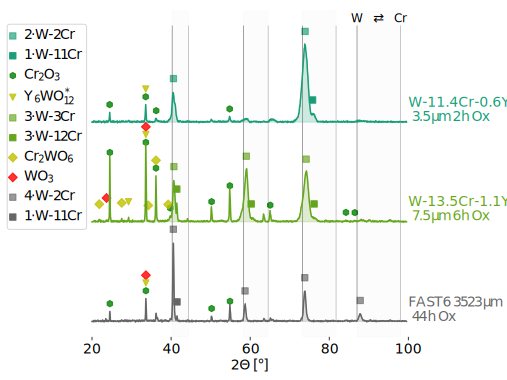

In [14]:
### dic_peaks = {} #open new dict where the name and peak data is filled in
fig1 = plt.figure(facecolor='white')
ax1 = plt.axes(frameon=False)
ax1.set_frame_on(False)
ax1.get_xaxis().tick_bottom()
ax1.axes.get_yaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(True)
xlabel(u'$2\,\Theta$ [°]')
ylabel(u'Intensity [a.u.]')

#import Plot_XRD #imports the look of the plot no boder and the right x and y labels...
dic_peaks = {}

for i in reversed(range(0,len(meas))):
    x_all = dataSets[i][:,0]
    x = x_all[(start < x_all) & (x_all < stop)]
    y=peakhight/sec[i]*(dataSets[i][(start <x_all) & (x_all<stop),1])+scale*i
    ###################producing the lines area for The W-Cr BCC systems#################
    if (metal== True) & (oixdes==True):
        comun_shift = 0
    else:
        comun_shift = 1
    if metal== True:
        if i == 0:
            for j in range(len(W)):
                plt.vlines(W[j],0,(scale)*len(name)-6, lw=0.5,alpha=0.7)
                plt.axvspan(W[j], Cr[j] if Cr[j]<stop else stop, alpha=0.0125, color='black')
            plt.text(W[-1-comun_shift],(scale)*len(name),'W',fontsize = 12,horizontalalignment='center')
            for j in range(len(Cr)-comun_shift):
                plt.vlines(Cr[j],0,(scale)*len(name)-6, lw=0.5,alpha=0.4)
            plt.text(Cr[-1-comun_shift],(scale)*len(name),'Cr',fontsize = 12,horizontalalignment='center')
            plt.text(W[-1-comun_shift]+(Cr[-1-comun_shift]-W[-1-comun_shift])/2,(scale)*len(name),\
                     u'\u21C4',fontsize = 13,horizontalalignment='center')
        
    plot(x,y,c=color[i])
    fill(x, y, zorder=10,color=color[i],alpha=0.2)
    plt.text(stop,peakhight/sec[i]*(dataSets[i][100,1])+scale*i, name[i], color=color[i])#prints the name to the line
    print name[i]
    ## smoothing the data for the fit, makes fiitig more reliable:
    window = (len(x)/(stop-start))/Smooth   
    window = window if window%2 != 0 else window+1#checks is window is odd
    y_smooth = savgol_filter(y, window_length=window, polyorder=3)
    
    #==================================================================================#
    #              FIT/Plot concentrations... Vegard approximation                     #
    #==================================================================================#
    if (metal == True) and (name[i] not in list_of_none_metal):
        ##making the fit on the smoothed data
        indexes = peakutils.indexes(y_smooth, thres=minpeak2[i]/peakhight, min_dist=len(x)/peaknumber2[i])
        #finding peak index position /max(y)
        peaks_x2 = peakutils.interpolate(x, y_smooth, ind=indexes, width=window)#gausian refit for better precision
        if name[i] in non_gausian_metal:
             peaks_x2 = x[indexes]
        peaks_x2 = np.where(np.abs(peaks_x2-x[indexes])>1.,x[indexes],peaks_x2)#check wrong fit
        aWCr = peak(peaks_x2)#calulating the lattice constant for the bcc phase
        x_reduced, yin = relevant(peaks_x2)# reducing all peaks to the relevant bcc ones  (here just metal)
        y_reduced = y[indexes[yin]]#same for peakhight
        colorX = color[i]
        inds =[] #pruce empty list to fill with indices for each bin (histogram) idividualy
        print len(aWCr),'{:.2}'.format(aWCr.std()),'standart deviation lattice constant'
        
        if aWCr.std()>0.003: #filtering if there are more than one cubic phase, only shown if 3 or more## turn off by increasing standdeviation
            #check length of a, and find proper spacing of bins
            print 'ON!!length{}'.format(len(aWCr)), sort(aWCr)#tells u that filtering is active
            if len(aWCr)<=4:
                bin_num = len(aWCr)-1 if (len(aWCr)-1)>=3 else 3  #for small number of peaks
                print 'small number of peaks<=4', 'bin_num=', bin_num
            elif aWCr.std()>0.08:
                bin_num = len(aWCr)/2+len(aWCr)%2+10####<<<-4---------------###for big number of peaks, as than finer distinguishing is needed
                print 'huge std of a'
            else:
                bin_num = len(aWCr)/2+len(aWCr)%2+2####<<<-4---------------###for big number of peaks, as than finer distinguishing is needed
                print 'big number of peaks>4'
            #creats bins which are used to filter the data (equivalent to a histogram)
            bins = np.linspace(aWCr.min(),aWCr.max()+0.00000001,bin_num)
            print 'len(bins)',len(bins), bins
            #creats temporary emtpy np.array in the right size
            counts = np.zeros_like(bins)
            # find the appropriate bin foreach a, right means right vlaue<bin index>bin-index
            k = np.searchsorted(bins, aWCr,side='right')
            # add one for every fitting value to a bin
            np.add.at(counts, k, 1)
            #creats array of lenght bins with the aproperiat index values of bins
            v_ = np.arange(len(bins))
            #checks at which bin index the count is higher than minmal_count 2(default or 1 for thinfilm samples) (so significant)
            vin =  v_[(counts>2)]
            #check if any True value is found
            if (((counts>2).sum() == False) or (minimal_count < 2)):
                vin =  v_[(counts>1)]#if not, reduce condition to more than 1
                print 'FILTERT with>1', (counts>1)
            if name[i] in exeption:
                vin =  v_[(counts>0)]#if not, reduce condition to more than 1
                print 'FILTERT expection with=1,', (counts>0),vin
            for n in range(len(vin)):
                inds.append([k==vin[n]])    
        else:
            inds.append([aWCr==aWCr])
            vin  = list([True])
            print 'only one phase'
        #print 'inds',inds
        for n in reversed(range(len(vin))):
            atPerCr = 1.-(aWCr[inds[n]]-aCr)/(aW-aCr)#calculate at% Cr
            wtPerCr = atPerCr*atomicMassCr/(atomicMassW*(1-atPerCr)+atPerCr*atomicMassCr)# wt%Cr
            scatter(x_reduced[inds[n]],y_reduced[inds[n]]+0.18*peakhight, s=40, marker='s'\
                    ,color = color[i], alpha = len(vin)/(len(vin)+float(n))\
                    ,label = '{}$\cdot$W-{:.0f}Cr'.format(len(wtPerCr),abs(wtPerCr.mean())*100))

    #===============================================================================================#
    #                      Fitting data from libary (pure Cr,W and oxides)                          #
    #===============================================================================================#
    indexes = peakutils.indexes(y_smooth, thres=minpeak[i], min_dist=len(x)/peaknumber[i]) # , fontsize = 16 finding peak index position /max(y)
    peaks_x = peakutils.interpolate(x, y_smooth, ind=indexes, width=window)#gausian fit better presition
    #check if any peaks were lost and if get rid of them
    peaks_x = np.where(np.abs(peaks_x-x[indexes])>0.8,x[indexes],peaks_x)#checks if fit is off after interpolation by a sustancial amount.
    dic_peaks[name[i]] = peaks_x
    rel = peaks_x==peaks_x#takes all, in the list into consideration
    #recues double fitting in the alloy zones, can be turned of for specific samples by adding to the list_of_none_metal
    if (metal == True) & (name[i] not in list_of_none_metal):
        rel = irrelevant(peaks_x)
        peaks_x = peaks_x[rel]
     
    # ad a minmal diff function to the original so no double fitting...?? possible?
    if (oixdes==True) and (name[i] not in list_of_none_oxed):
        #print name[i], (name[i] not in list_of_none_oxed)
        for key in dic:
            temp_index_ox = ox_index(peaks_x,dic[key], uncertanty=0.07)#0.15)# for BULK
            #print key,len(peaks_x),
            dic_array = np.array(dic[key])
            peak_array = peaks_x[temp_index_ox]
            print key, len(temp_index_ox), '{:.3f}'.format(np.abs(peak_array[ox_index(peak_array,dic[key])]-dic_array[ox_index(dic[key],peak_array)]).mean())
            if (len(temp_index_ox) >= 1):#checks if array is empty=1, or filters for more than one peak
                #checks the average distance fit position and databank
                if (np.abs(peak_array[ox_index(peak_array,dic_array)]-dic_array[ox_index(dic_array,peak_array)]).mean()<0.056):
                    scatter(peaks_x[temp_index_ox],y[indexes][rel][temp_index_ox]+(0.1+dic_marker[key][2])*peakhight\
                            ,marker=dic_marker[key][0],color=dic_marker[key][1],s = 40,alpha=0.8\
                            ,label = key if key not in plt.gca().get_legend_handles_labels()[1] else '')
                             #label = checks if the key is already in the list of labels and so avoids double naming of labels
    print '\n'
dic_oxtest = dic_peaks

if left== True:
    plt.legend(handlelength=0, bbox_to_anchor=(.05, 0.98), ncol=1, mode=None)#left
else:
    plt.legend(bbox_to_anchor=(0., 1., 1.05, -.102), handlelength=0, ncol=4, mode="expand")#, borderaxespad=0.)#top

print Folder
#For last plot make '_' for testing '_test'
test = '_test'
print '%s/06_XRD%snew%s'%(Folder,test,Folder)

savefig('%s/06_XRD%snew%s.svg'%(Folder,test,Folder), bbox_inches = 'tight', transparent=True)#saves the fig in chooesen format
savefig('%s/06_XRD%snew%s.pdf'%(Folder,test,Folder), bbox_inches = 'tight', transparent=True)#bbox_inches ='
savefig('%s/06_XRD%snew%s.png'%(Folder,test,Folder), bbox_inches = 'tight', transparent=True,dpi = 300)#bbox_inches ='

# End
Here the fitting parameters can be tested if they are reasonably well for the Folder

In [15]:
#rouding based Fitting---> slower but little more stable
def index_round(peaks_x,ox,dec = 1):
    peaks_x = np.array(peaks_x)
    ox = np.array(ox)
    a = np.round(peaks_x, decimals = dec)
    b = np.round(ox, decimals = dec)
    c = np.isin(a,b)
    d = np.isin(b,a)
    #if len(c) > len(d):
     #   c = np.searchsorted(a,a[c])
    #else:
    #    c = np.searchsorted(a[c],b[d],side='left')
    return c